<a href="https://colab.research.google.com/github/DevBauti/ALittleBitofColab/blob/main/vintage_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas
!pip install matplotlib
!pip install numpy

In [ ]:
#
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#config pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [ ]:
#connect data
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
credit = pd.read_csv('/content/drive/MyDrive/credit_risk/credit_record.csv')
aplication = pd.read_csv('/content/drive/MyDrive/credit_risk/application_record.csv')

In [ ]:
credit.head(10)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C
7,5001712,-3,C
8,5001712,-4,C
9,5001712,-5,C


In [ ]:
aplication.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
8,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
9,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0


In [ ]:
# search id in both table
c = len(set(credit['ID']))
print(f'unique id in credit {c}')
a = len(set(aplication['ID']))
print(f'unique id in aplication {a}')

unique id in credit 45985
unique id in aplication 438510


In [ ]:
 f = len(set(credit['ID']).intersection(set(aplication['ID'])))
 print(f'id between both table {f}')

id between both table 36457


In [ ]:
grouped = credit.groupby('ID')

# convert credit data to wide format which every ID in row

pivot_tb = credit.pivot(index='ID', columns='MONTHS_BALANCE', values='STATUS')
pivot_tb['open_month'] = grouped['MONTHS_BALANCE'].min()
pivot_tb['close_month'] = grouped['MONTHS_BALANCE'].max()
#
pivot_tb['ID'] = pivot_tb.index
pivot_tb = pivot_tb[['ID', 'open_month', 'close_month']]
#
pivot_tb['window'] = pivot_tb['close_month'] - pivot_tb['open_month']
pivot_tb.reset_index(drop=True, inplace=True)

credit = pd.merge(credit, pivot_tb, on='ID', how='left')


#join calculated information
credit0 = credit.copy()
credit0 = credit0[credit0['window'] >= 20] #deleted users whose observe window less than 20
credit0['status'] = np.where(
    (credit0['STATUS']=='2')|
    (credit0['STATUS']=='3')|
    (credit0['STATUS']=='4')|
    (credit0['STATUS']=='5'), 1, 0) #analyze > 60 days past due

credit0['status'] = credit0['status'].astype(np.int8) # 1: overdue 0: not
credit0['month_on_book'] = credit0['MONTHS_BALANCE'] - credit0['open_month'] # calculate month on book: how many months after opening account
credit0.sort_values(by=['ID', 'month_on_book'], inplace=True)
credit1 = credit0.copy()

#denominator
denominator = pivot_tb.groupby(['open_month']).agg({'ID': ['count']}) # count how many users in evey month the account was opened
denominator.reset_index(inplace=True)
denominator.columns = ['open_month', 'sta_sum']

#vintage table

vintage = credit1.groupby(['open_month', 'month_on_book']).agg({'ID': ['count']})
vintage.reset_index(inplace=True)
vintage.columns = ['open_month', 'month_on_book', 'sta_count']
vintage['due_count'] = np.nan
vintage = vintage[['open_month', 'month_on_book', 'due_count']]

#remove added column
vintage = pd.merge(vintage, denominator, on =['open_month'], how='left')
#
print(vintage.head(10))

   open_month  month_on_book  due_count  sta_sum
0         -60              0        NaN      415
1         -60              1        NaN      415
2         -60              2        NaN      415
3         -60              3        NaN      415
4         -60              4        NaN      415
5         -60              5        NaN      415
6         -60              6        NaN      415
7         -60              7        NaN      415
8         -60              8        NaN      415
9         -60              9        NaN      415


In [ ]:
vintage1 = vintage.copy()
for j in range(-60,1):
  ls = []
  for i in range(0,61):
    due = list(credit1[(credit1['status']==1) & (credit1['month_on_book']==i) & (credit1['open_month']==j)]['ID'])
    ls.extend(due)
    vintage1.loc[(vintage1['month_on_book']==i) & (vintage1['open_month']==j) , 'due_count'] = len(set(ls))

vintage1['sta_rate']  = vintage1['due_count'] / vintage['sta_sum']
print(vintage1.head(10))

   open_month  month_on_book  due_count  sta_sum  sta_rate
0         -60              0        0.0      415  0.000000
1         -60              1        0.0      415  0.000000
2         -60              2        0.0      415  0.000000
3         -60              3        0.0      415  0.000000
4         -60              4        0.0      415  0.000000
5         -60              5        1.0      415  0.002410
6         -60              6        1.0      415  0.002410
7         -60              7        3.0      415  0.007229
8         -60              8        3.0      415  0.007229
9         -60              9        4.0      415  0.009639


In [ ]:
vintage_wide = vintage1.pivot(index='open_month', columns='month_on_book', values='sta_rate')
vintage_wide.head(10)

month_on_book,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
open_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-60,0.0,0.000000,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,0.009639,0.009639,0.012048,0.014458,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.019277,0.019277,0.019277,0.019277,0.021687,0.021687,0.021687,0.021687,0.024096,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,0.0,0.000000,0.000000,0.004926,0.004926,0.004926,0.007389,0.007389,0.007389,0.012315,0.012315,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.022167,0.024631,0.024631,0.027094,0.027094,0.027094,0.027094,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.032020,0.032020,0.032020,0.032020,0.032020,0.032020,NaN
-58,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,0.006818,0.011364,0.013636,0.013636,0.013636,0.013636,0.013636,0.013636,0.015909,0.018182,0.018182,0.018182,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,0.0,0.000000,0.000000,0.000000,0.002500,0.002500,0.002500,0.007500,0.007500,0.007500,0.007500,0.007500,0.010000,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.022500,0.022500,0.022500,0.022500,0.022500,0.022500,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN,NaN
-56,0.0,0.000000,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,0.021277,0.025532,0.029787,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN
-55,0.0,0.000000,0.002058,0.006173,0.012346,0.016461,0.022634,0.022634,0.022634,0.024691,0.024691,0.024691,0.026749,0.032922,0.034979,0.037037,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.041152,0.041152,0.041152,0.041152,0.041152,0.041152,0.041152,0.043210,0.043210,0.043210,0.043210,0.043210,0.043210,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,NaN,NaN,NaN,NaN,NaN
-54,0.0,0.000000,0.000000,0.002137,0.004274,0.004274,0.006410,0.012821,0.012821,0.017094,0.019231,0.019231,0.023504,0.027778,0.027778,0.029915,0.029915,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,NaN,NaN,NaN,NaN,NaN,NaN
-53,0.0,0.

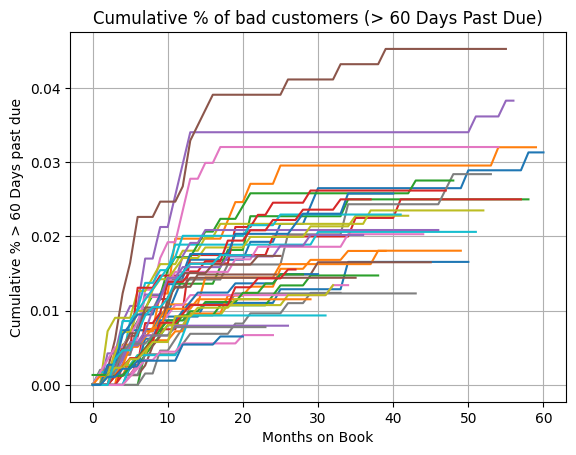

In [ ]:
#plot vintage line chart
plt.rcParams['figure.facecolor'] = 'white'
vintage2 = vintage_wide.replace(0,np.nan)
lst = [i for i in range(0,61)]
vintage_wide[lst].T.plot(legend = False, grid = True, title = 'Cumulative % of bad customers (> 60 Days Past Due)')

plt.xlabel('Months on Book')
plt.ylabel('Cumulative % > 60 Days past due')
plt.show()

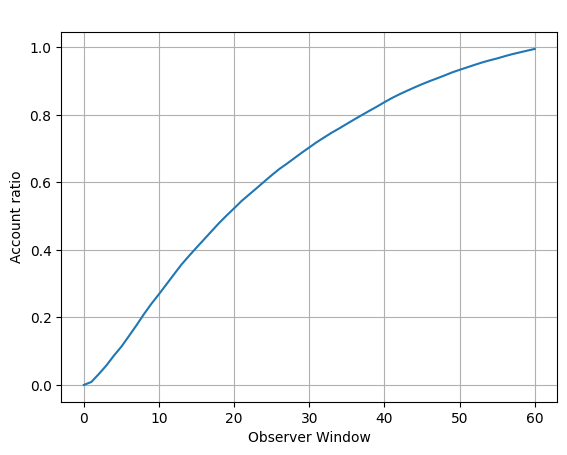

In [ ]:
lst = []

for i in range(0,61):
  ratio = len(pivot_tb[pivot_tb['window']<i]) / len(set(pivot_tb['ID']))
  lst.append(ratio)

pd.Series(lst).plot(legend = False, grid= True, title = ' ')
plt.xlabel('Observer Window')
plt.ylabel('Account ratio')
plt.show()